# Classification
In this notebook we classify the CT/PET scans of lung cancer cases by tumor type. 
We are doing this as a baseline task to validate our data loading pipeline.
Most code is taken from [this tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import transforms
import time
import os
import copy
from utils.wandb import start_wandb_run, wandb_watch, wandb_log
from eval.reconstruction_viusalization import compare_images


cudnn.benchmark = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    torch.cuda.empty_cache() 
    
cpu = torch.device("cpu")

torch.cuda.list_gpu_processes()

/dhc/home/tobias.fiedler/conda3/envs/advancedML/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'pynvml module not found, please install pynvml'

# Defining datasets (train/validation) 

In [2]:
IMAGE_RESOLUTION = 64

In [3]:
from lungpetctdx_dataset import LungPetCtDxDataset_TumorClass3D
from ct_dataset import NormalizationMethods
import numpy as np


class Resize3D(torch.nn.Module):
    def __init__(self, size=64):
        super().__init__()
        self.size = size
        self.resize = transforms.Resize(size)

    def forward(self, img):
        new_shape = list(img.shape)
        new_shape[-2] = self.size
        new_shape[-3] = self.size
        out = torch.tensor(np.zeros(shape=new_shape, dtype=np.float32))
        for i in range(img.shape[-1]):
            tmp = self.resize(img[..., i])
            out[..., i] = tmp
        return out

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(size={self.size})"


class Grayscale3D(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.transform = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Grayscale(),
                transforms.PILToTensor(),
            ]
        )

    def forward(self, img):
        new_shape = list(img.shape)
        new_shape[0] = 1
        out = torch.tensor(np.zeros(shape=new_shape, dtype=np.float32))
        for i in range(img.shape[-1]):
            tmp = self.transform(img[..., i])
            out[..., i] = tmp
        return out

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(size={self.size})"


postprocess = transforms.Compose(
    [
        Grayscale3D(),
        Resize3D(IMAGE_RESOLUTION),
    ]
)
ds = LungPetCtDxDataset_TumorClass3D(
    cache=True,
    slices_per_sample=30,
    samples_per_scan=4,
    postprocess=postprocess,
    exclude_classes=[
        "Small Cell Carcinoma",
        "Large Cell Carcinoma",
    ],
    sampling="undersample"
)

Undersampled from 186 items to 70


/dhc/home/tobias.fiedler/conda3/envs/advancedML/lib/python3.10/site-packages/sklearn/utils/validation.py:856: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)


In [4]:

trainSet, valSet = ds.subject_split(0.2)
dataloaders = {
    "val": torch.utils.data.DataLoader(valSet, batch_size=4, shuffle=True, num_workers=8),
    "train": torch.utils.data.DataLoader(trainSet, batch_size=4, shuffle=True, num_workers=8),
}
num_classes = len(ds.class_names)
dataset_sizes = {"train": len(trainSet),"val": len(valSet)}

/dhc/home/tobias.fiedler/conda3/envs/advancedML/lib/python3.10/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
# model = torch.load("test")

# Defining model 

## 3DUcaps

In [6]:
from capsule_net_3d import CapsNet
from capsnet_config import Config


config = Config(
    cnn_in_channels=1,
    input_width=IMAGE_RESOLUTION,
    input_height=IMAGE_RESOLUTION,
    dc_in_channels=504,
    reconstruction_loss_factor=0.10026636110077232,
    dc_num_capsules=num_classes,
    out_capsule_size=16,
    # Num labelled 0 tensor(5682)
    # Num labelled 1 tensor(47677)
    #class_weights=torch.tensor([1., 5682/47677.]).to(device)
)

model = CapsNet(config)

start_wandb_run(config)

wandb_watch(model)
model.to(device)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tfiedlerdev (7-vs-capsule). Use `wandb login --relogin` to force relogin


CapsNet(
  (conv_layer): ConvLayer(
    (conv): Conv3d(1, 256, kernel_size=(9, 9, 9), stride=(1, 1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0): Conv3d(256, 32, kernel_size=(9, 9, 9), stride=(2, 2, 2))
      (1): Conv3d(256, 32, kernel_size=(9, 9, 9), stride=(2, 2, 2))
      (2): Conv3d(256, 32, kernel_size=(9, 9, 9), stride=(2, 2, 2))
      (3): Conv3d(256, 32, kernel_size=(9, 9, 9), stride=(2, 2, 2))
      (4): Conv3d(256, 32, kernel_size=(9, 9, 9), stride=(2, 2, 2))
      (5): Conv3d(256, 32, kernel_size=(9, 9, 9), stride=(2, 2, 2))
      (6): Conv3d(256, 32, kernel_size=(9, 9, 9), stride=(2, 2, 2))
      (7): Conv3d(256, 32, kernel_size=(9, 9, 9), stride=(2, 2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (reconstraction_layers): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplac

# Setup training

In [7]:
from tqdm.notebook import tqdm
from utils.mask import mask_image

import numpy as np
from train import train_model, predicted_indices_from_outputs, plot_losses

# Define training parameters

In [8]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.00740223274235431)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


# Run training

In [9]:
from train import train_model


(model, history) = train_model(
    model, exp_lr_scheduler, dataloaders["train"], dataloaders["val"], num_epochs=5
)




/dhc/home/tobias.fiedler/conda3/envs/advancedML/lib/python3.10/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: [1/5], Batch: [57/57], batch loss: 0.6926| RUNNING  acc: 0.4912, combined l.: 0.7115, class. l.: 0.7115, reconstr. l.: 0.0000
Phase train finished
Epoch: [1/5], Batch: [13/13], batch loss: 0.7062| RUNNING  acc: 0.4615, combined l.: 0.6945, class. l.: 0.6945, reconstr. l.: 0.0000
Phase val finished
Epoch: [2/5], Batch: [57/57], batch loss: 0.7001| RUNNING  acc: 0.4868, combined l.: 0.6982, class. l.: 0.6982, reconstr. l.: 0.0000
Phase train finished
Epoch: [2/5], Batch: [13/13], batch loss: 0.6929| RUNNING  acc: 0.5769, combined l.: 0.6924, class. l.: 0.6924, reconstr. l.: 0.0000
Phase val finished
Epoch: [3/5], Batch: [57/57], batch loss: 0.7090| RUNNING  acc: 0.5219, combined l.: 0.6956, class. l.: 0.6956, reconstr. l.: 0.0000
Phase train finished
Epoch: [3/5], Batch: [13/13], batch loss: 0.6909| RUNNING  acc: 0.4615, combined l.: 0.6945, class. l.: 0.6945, reconstr. l.: 0.0000
Phase val finished
Epoch: [4/5], Batch: [57/57], batch loss: 0.6698| RUNNING  acc: 0.5482, combined l

In [10]:
history[0].get_count_per_class("train", 2)

[116, 112]

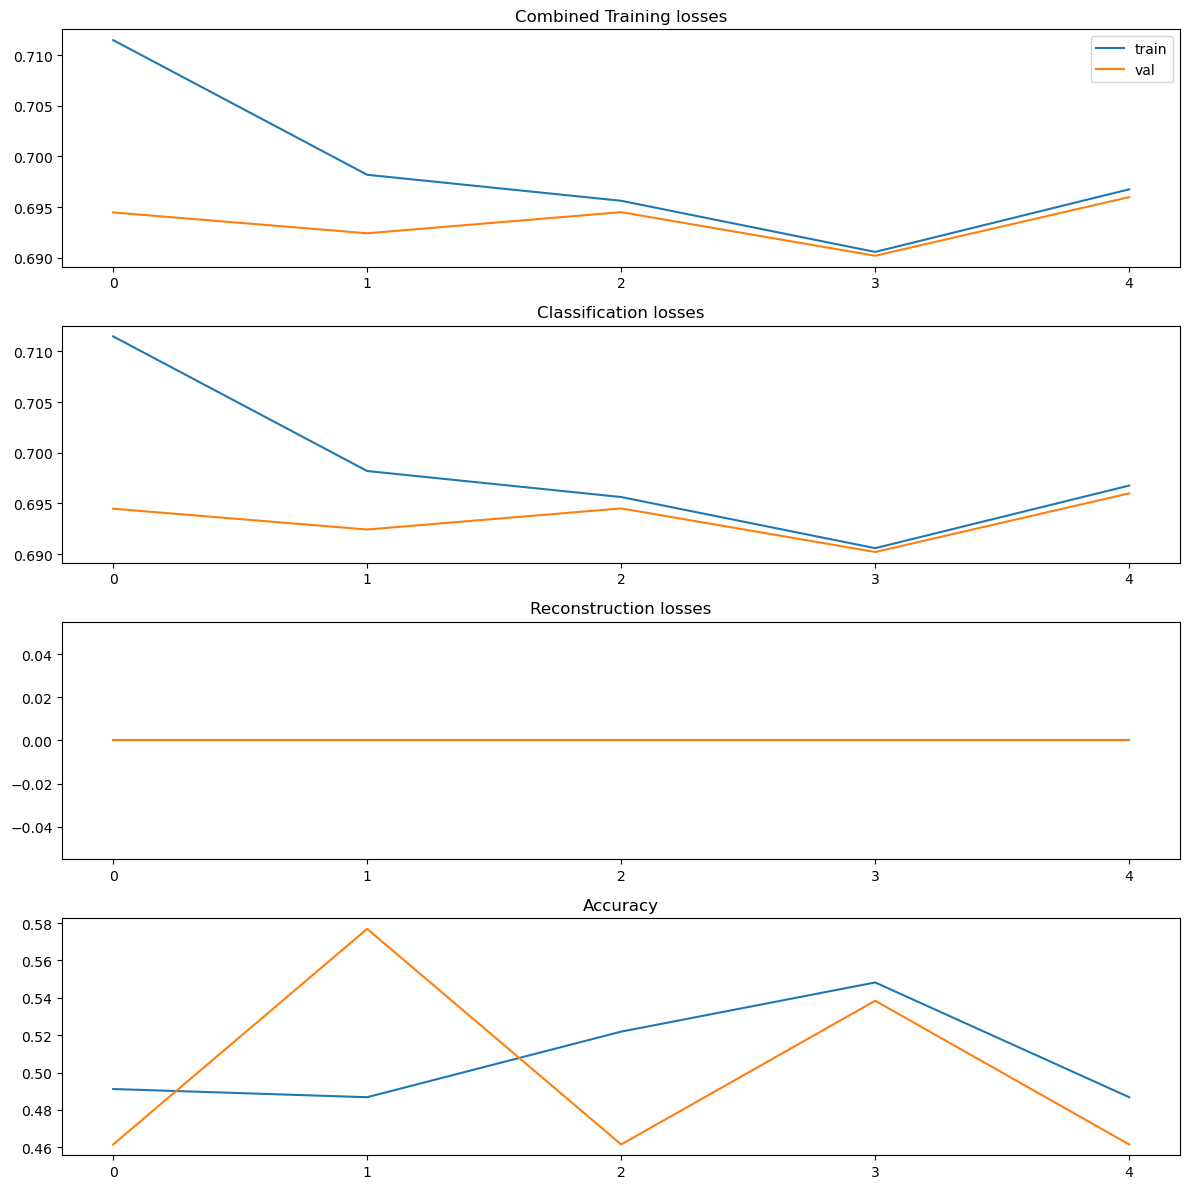

In [11]:
plot_losses(history)

In [12]:
torch.save(model, "test.torch")

# Evaluation

Num labelled 0 tensor(24)
Num labelled 1 tensor(28)


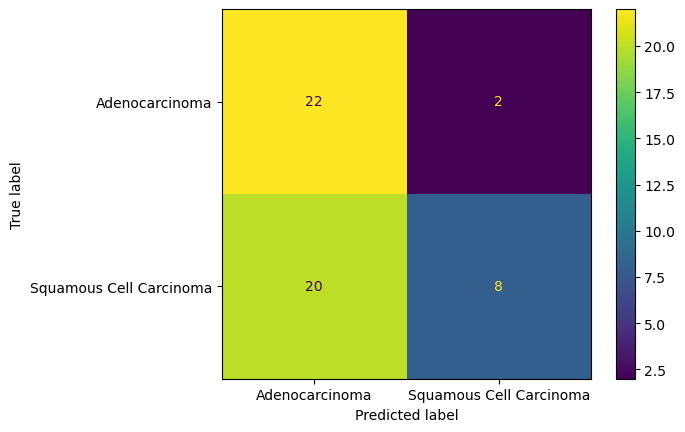

F1-score: 0.534412955465587


In [13]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

num_labelled_1 = 0
num_labelled_0 = 0
y_true = np.array([])
y_pred = np.array([])
with torch.no_grad():
    for i, (inputs, classes, bboxes) in enumerate(dataloaders['val']):
        x = np.unique(classes, axis=0)
        if len(x) < 2:
            pass
            #print("Skip!")
            # continue
        _, classIndices = torch.max(classes.cpu(), 1)

        num_labelled_1 += classIndices.sum()
        num_labelled_0 += classIndices.size()[0]-classIndices.sum()
    
        
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs, _, _ = model(inputs)
        
        
        preds = predicted_indices_from_outputs(outputs).cpu()
        _, labels = torch.max(classes.cpu(), 1)
    
        y_true = np.concatenate((y_true, labels))
        y_pred = np.concatenate((y_pred, preds))

print("Num labelled 0", num_labelled_0)
print("Num labelled 1", num_labelled_1)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=ds.class_names)
disp.plot()
plt.show()
print("F1-score:",f1_score(y_true, y_pred, average="weighted") )

# Visualize reconstruction samples


In [14]:
with torch.no_grad():
    
    inputs, classes, bounding_boxes = next(iter(dataloaders['val']))
    #reconstruction_targets = torch.tensor(list(map(mask_image, inputs, bounding_boxes)))
    #reconstruction_targets = reconstruction_targets.to(device)
    inputs = inputs.to(device)
    reconstruction_targets = inputs
    classes = classes.to(device)
    outputs, reconstructions, _ = model(inputs)
    preds = predicted_indices_from_outputs(outputs).cpu()
    _, labels = torch.max(classes.cpu(), 1)

    print("Inputs min",inputs.min().item(), "max", inputs.max().item(), "mean", inputs.mean().item(), "std", inputs.std().item())
    print("reconstruction_targets min",reconstruction_targets.min().item(), "max", reconstruction_targets.max().item(), "mean", reconstruction_targets.mean().item(), "std", reconstruction_targets.std().item())
    print("reconstructions min",reconstructions.min().item(), "max", reconstructions.max().item(), "mean", reconstructions.mean().item(), "std", reconstructions.std().item())
    print("inputs shape", inputs.size())
    print("reconstructions shape", reconstructions.size())
    compare_images([(inputs[i], reconstruction_targets[i],reconstructions[i]) for i in range(reconstructions.size(0))], preds, labels)

/dhc/home/tobias.fiedler/conda3/envs/advancedML/lib/python3.10/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Inputs min 0.0 max 254.5 mean 154.7183074951172 std 53.99003982543945
reconstruction_targets min 0.0 max 254.5 mean 154.7183074951172 std 53.99003982543945
reconstructions min 0.43492645025253296 max 0.5596834421157837 mean 0.49970370531082153 std 0.01495501771569252
inputs shape torch.Size([4, 1, 64, 64, 30])
reconstructions shape torch.Size([4, 1, 64, 64])


ValueError: axes don't match array

<Figure size 1000x2000 with 0 Axes>

# Explain Model Performance
Using SHAP

# Count classes

In [ ]:
numClass0 = 0
numClass1 = 0

for i, (inputs, classes, bboxes) in enumerate(dataloaders['val']):
# for i, (inputs, classes) in enumerate(dataloaders['val']):
    #_, labels = torch.max(classes.cpu(), 1)
    #batchNum1 = torch.sum(labels)
    #numClass1 += batchNum1
    #numClass0 += len(labels)-batchNum1
    print(inputs.size())
    break

print("Samples of class 0: ", numClass0)
print("Samples of class 1: ", numClass1)


torch.Size([128, 1, 128, 128])
Samples of class 0:  0
Samples of class 1:  0


# Explain Model Performance
Using SHAP

In [ ]:
inputs[1:4]

tensor([[[[-0.8925, -0.8925, -0.8925,  ..., -0.8925, -0.8925, -0.8925],
          [-0.8925, -0.8925, -0.8925,  ..., -0.8925, -0.8925, -0.8925],
          [-0.8925, -0.8925, -0.8925,  ..., -0.8925, -0.8925, -0.8925],
          ...,
          [-0.8925, -0.8925, -0.8925,  ..., -0.8925, -0.8925, -0.8925],
          [-0.8925, -0.8925, -0.8925,  ..., -0.8925, -0.8925, -0.8925],
          [-0.8925, -0.8925, -0.8925,  ..., -0.8925, -0.8925, -0.8925]]],


        [[[-0.3927, -0.3927, -0.3927,  ..., -0.3927, -0.3927, -0.3927],
          [-0.3927, -0.3927, -0.3927,  ..., -0.3927, -0.3927, -0.3927],
          [-0.3927, -0.3927, -0.3927,  ..., -0.3927, -0.3927, -0.3927],
          ...,
          [-0.3927, -0.3927, -0.3927,  ..., -0.3927, -0.3927, -0.3927],
          [-0.3927, -0.3927, -0.3927,  ..., -0.3927, -0.3927, -0.3927],
          [-0.3927, -0.3927, -0.3927,  ..., -0.3927, -0.3927, -0.3927]]],


        [[[-0.4006, -0.4006, -0.4006,  ..., -0.4006, -0.4006, -0.4006],
          [-0.4006, -0.400

In [ ]:
model = torch.load("test.torch")

In [ ]:
def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x

def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x

transform= [
    # torchvision.transforms.Lambda(nhwc_to_nchw),
    # torchvision.transforms.Lambda(lambda x: x*(1/255)),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

inv_transform= [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

In [ ]:
import shap

inputs, classes, bounding_boxes = next(iter(dataloaders['train']))
inputs = transform(inputs)

def predict(img_batch):
    # print(f'Predict {img_batch.shape}')
    # print(img_batch.shape)
    img_batch = nhwc_to_nchw(torch.tensor(img_batch))
    is_single = False
    if img_batch.shape[0] == 1:
        is_single = True
        img_batch = img_batch.repeat(2,1,1,1)
    # print(is_single)
    # print(img_batch.shape)
    img_batch = img_batch.to(device)
    output, _, _ = model(img_batch)
    if is_single:
        output = output[0:1, :]
    output = softmax_output(output)
    # print(output.shape)
    return output.detach().cpu()


def softmax_output(outputs):
    classes = torch.sqrt((outputs ** 2).sum(2))
    output = torch.nn.Softmax(dim=1)(classes)
    return np.squeeze(output.detach().cpu(), -1)

This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]], dtype=torch.float64)

In [ ]:
# Based on https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20MobilenetV2%20using%20the%20Partition%20explainer%20%28PyTorch%29.html
model.to(device)
n_top_prediction = len(ds.class_names)
n_evals = 50000
# define a masker that is used to mask out partitions of the input image.
# masker_blur = shap.maskers.Image("blur(128,128)", inputs[0].shape)

# create an explainer with model and image masker
masker = shap.maskers.Image("blur(32, 32)", inputs[0].shape)
explainer = shap.Explainer(predict, masker=masker, output_names=ds.class_names)

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
input_images = inputs[:10].cpu().numpy()
# print(input_images.shape)
shap_values = explainer(input_images, max_evals=n_evals, batch_size=inputs.shape[0], outputs=shap.Explanation.argsort.flip[:2])


Partition explainer: 11it [29:36, 177.62s/it]                        


In [ ]:
def write_bbox_in_matrix(data, bbox):
    width = data.shape[0]
    max = np.max(data)
    x_min, y_min, x_max, y_max = np.floor(bbox * width).numpy().astype(int)
    if x_max == width or y_max == width:
        return data
    data[x_min:x_max, y_min] = max
    data[x_max, y_min:y_max] = max
    data[x_min:x_max, y_max] = max
    data[x_min, y_min:y_max] = max
    return data

In [ ]:
# Add bbox to images
shap_values.data = np.array(list(map(write_bbox_in_matrix, shap_values.data, bounding_boxes[0:10])))

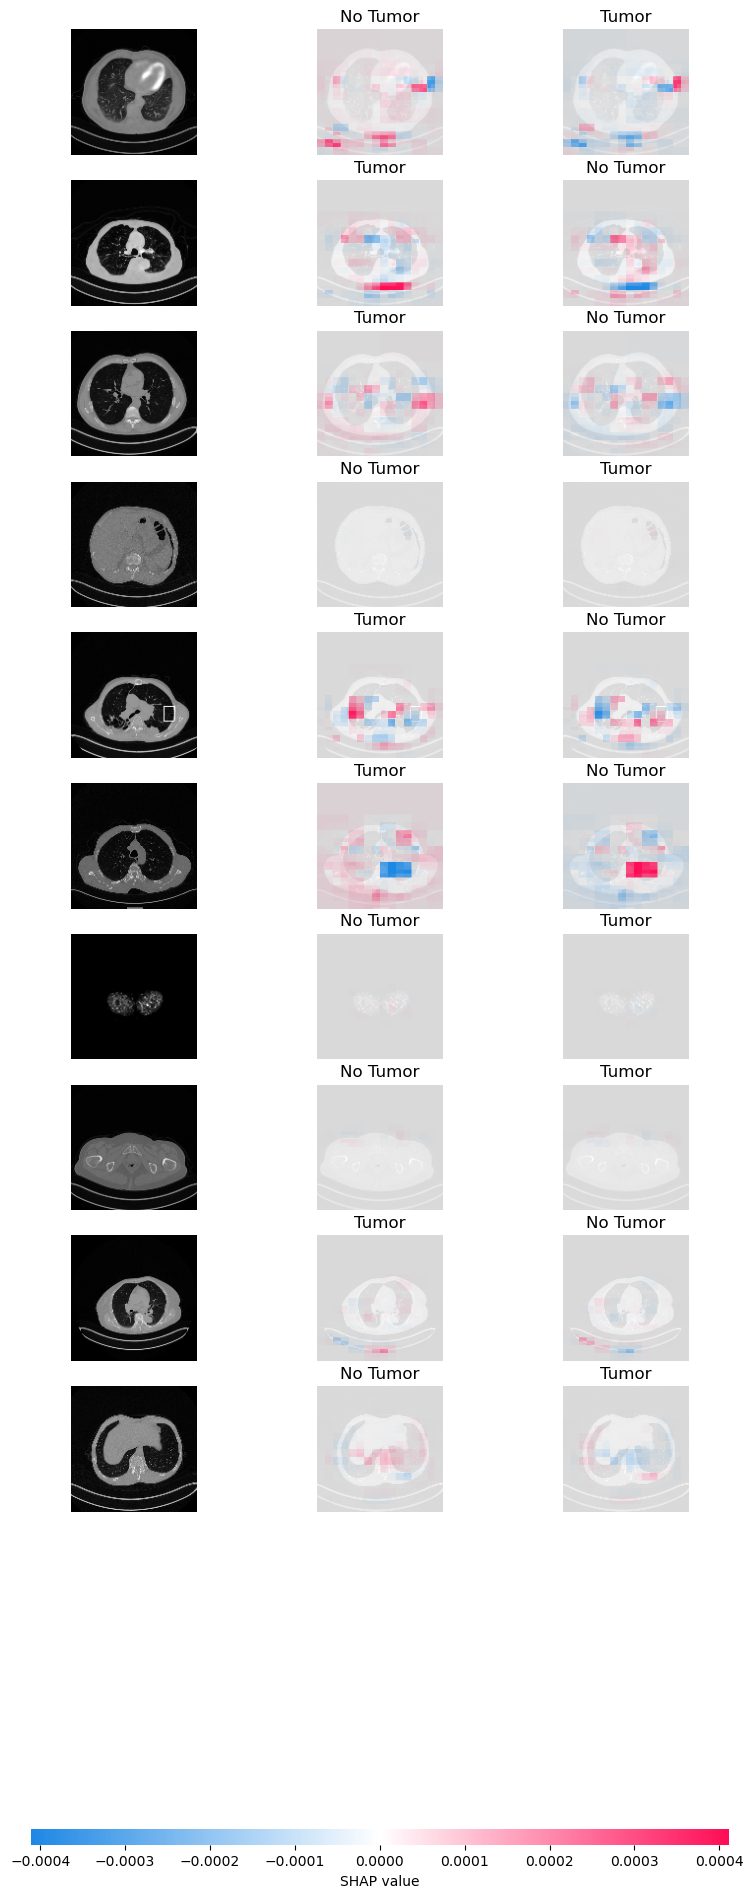

In [ ]:
shap.image_plot(shap_values)